In [ ]:
# Copyright (C) 2024  Jose Ángel Pérez Garrido & Pablo Ben Lestón
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.


# Dense Passage Retrieval State-of-the-Art Evaluation

## Students: Jose Ángel Pérez Garrido & Pablo Ben Lestón
### Master in Artificial Intelligence - University of Vigo

This notebook provides an exhaustive state-of-the-art analysis of Dense Passage Retrieval (DPR) models.
It includes the following key components:

1. **Dataset Loading**: Uses a variety of datasets from the BEIR benchmark.
2. **Model Evaluation**: Evaluates multiple DPR models and compares them.
3. **Metrics**: Evaluates using metrics such as nDCG, Recall, Precision, and MRR.

## Requirements
Ensure the following libraries are installed:
- `beir`: [BEIR](https://pypi.org/project/beir/) is a heterogeneous benchmark containing diverse IR tasks. It also provides a common and easy framework for evaluation of your NLP-based retrieval models within the benchmark.
- `sentence-transformers`: [Sentence Transformers framework](https://pypi.org/project/sentence-transformers/) provides an easy method to compute dense vector representations for sentences, paragraphs, and images. The models are based on transformer networks like BERT / RoBERTa / XLM-RoBERTa etc. and achieve state-of-the-art performance in various tasks. Text is embedded in vector space such that similar text are closer and can efficiently be found using cosine similarity.
- `scipy`: [SciPy](https://pypi.org/project/scipy/) is an open-source software for mathematics, science, and engineering. It includes modules for statistics, optimization, integration, linear algebra, Fourier transforms, signal and image processing, ODE solvers, and more.


In [1]:
!pip install beir
!pip install sentence-transformers
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.2/219.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.2 MB/s eta 0:00:00
  Created wheel for beir: filename=beir-2.0.0-py3-none-any.whl size=63550 sha256=4ae6cb8eb83f7385d8534c22d10682d26aba6f62c8f072810124573976196dc3
  Stored in directory: /root/.cache/pip/wheels/1c/14/96/c606ede3c10e9300ef771a6183af09d389459195ff5f854862
  Created wheel for p

Let's begin!

## Import dependencies and setup environment

In [2]:
from beir import util, LoggingHandler
from beir.retrieval import models
from beir.datasets.data_loader import GenericDataLoader
from beir.retrieval.evaluation import EvaluateRetrieval
from beir.retrieval.search.dense import DenseRetrievalExactSearch as DRES
from beir.retrieval.search.lexical import BM25Search
from sentence_transformers import SentenceTransformer
import logging
import pathlib
import os
import time
import numpy as np
import json, csv
import psutil
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_rel
import re

# Setup logging configuration
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

/usr/local/lib/python3.10/dist-packages/beir/util.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Load dataset

In [ ]:
def download_and_load_data(dataset: str, out_dir: str):
    """ Downloads and loads dataset. """
    url = f"https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{dataset}.zip"
    data_path = util.download_and_unzip(url, out_dir)
    corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="test")

    # Limit to the first 10 rows for each part (DEBUG)
    #corpus = dict(list(corpus.items())[:10])
    #queries = dict(list(queries.items())[:10])
    #qrels = {k: dict(list(v.items())[:10]) for k, v in list(qrels.items())[:10]}

    return corpus, queries, qrels

## Initialize DPR models

In [ ]:
def initialize_vanilla_dpr_retriever(batch_size: int = 128, corpus_chunk_size: int = 512 * 9999):
    """
    Initializes the vanilla DPR retriever with separate question and context encoders.
    """
    model = DRES(models.SentenceBERT((
        "facebook-dpr-question_encoder-multiset-base",
        "facebook-dpr-ctx_encoder-multiset-base",
        " [SEP] "),
          batch_size=batch_size, corpus_chunk_size = corpus_chunk_size))

    # Initialize the retrieval evaluation object
    retriever = EvaluateRetrieval(model, score_function="dot")
    return retriever

def initialize_dense_retriever(model_name: str, batch_size: int = 128, corpus_chunk_size: int = 512 * 9999):
    """ Initializes a dense retriever model. """
    model = DRES(models.SentenceBERT(model_name, batch_size=batch_size, corpus_chunk_size=corpus_chunk_size))
    retriever = EvaluateRetrieval(model, score_function="dot")
    return retriever

## Evaluation

In [ ]:
def evaluate_metrics(retriever, corpus, queries, qrels, k_values):
    """ Evaluate retrieval performance with given metrics. """
    start_time = time.time()
    results = retriever.retrieve(corpus, queries)
    inference_time = time.time() - start_time

    # Retrieve evaluation metrics
    ndcg, _map, recall, precision = retriever.evaluate(qrels, results, k_values)

    # Calculate MRR
    mrr = retriever.evaluate_custom(qrels, results, k_values, metric="mrr")

    # Return metrics as a dictionary
    return {
        "NDCG": ndcg,
        "MAP": _map,
        "Recall": recall,
        "Precision": precision,
        "MRR": mrr,
        "InferenceTime": inference_time
    }, results

In [ ]:
def error_analysis(queries, qrels, results):
    """ Analyze failed queries where relevant documents are not retrieved. """
    failed_queries = {}
    for query_id, relevant_docs in qrels.items():
        retrieved_docs = set(results.get(query_id, {}).keys())
        missing_docs = set(relevant_docs.keys()) - retrieved_docs
        if missing_docs:
            failed_queries[query_id] = {"missing_docs": missing_docs, "retrieved_docs": retrieved_docs}
    return failed_queries

In [ ]:
def save_results_to_file(results, file_path):
    """
    Save the evaluation results to a file in JSON or CSV format based on the file extension.

    Args:
    - results (Dict): Dictionary containing evaluation results.
    - file_path (str): Path to the output file. Supports `.json` or `.csv` formats.

    Raises:
    - ValueError: If the file extension is not supported.
    """
    # Determine the file format based on the extension
    _, file_extension = os.path.splitext(file_path)

    # Replace slashes (and other unwanted characters) to avoid "No such file or directory" problem
    file_path = re.sub(r'[\\/:*?"<>|]', '-', file_path)

    if file_extension == ".json":
        # Save as JSON
        with open(file_path, "w") as json_file:
            json.dump(results, json_file, indent=4)
        logging.info(f"Results successfully saved to {file_path} in JSON format.")

    elif file_extension == ".csv":
        # Save as CSV
        with open(file_path, "w", newline='') as csv_file:
            writer = csv.writer(csv_file)
            # Write headers
            writer.writerow(["Dataset", "Model", "Metric", "Value"])

            # Flatten nested dictionaries
            for metrics in results.items():
                for metric, value in metrics['metrics'].items():
                    writer.writerow([metric, value])
        logging.info(f"Results successfully saved to {file_path} in CSV format.")

    else:
        raise ValueError("Unsupported file format. Please use '.json' or '.csv'.")

def run_baseline_evaluation(datasets, k_values=[10, 50, 100], out_dir="datasets"):
    """ Main function to evaluate the baseline model. """
    all_metrics = {}
    for dataset in datasets:
      logging.info(f"Processing dataset: {dataset}")
      corpus, queries, qrels = download_and_load_data(dataset, out_dir)

      # Initialize Vanilla DPR baseline
      dpr_retriever = initialize_vanilla_dpr_retriever()
      baseline_metrics, _ = evaluate_metrics(
          dpr_retriever, corpus, queries, qrels, k_values
      )
      logging.info(f"Vanilla DPR Metrics for {dataset}: {baseline_metrics}")

      all_metrics[dataset] = baseline_metrics

      # Save results to a file
      save_results_to_file(baseline_metrics, file_path=f"evaluation_results_baseline_{dataset}.json")

    return all_metrics

def run_evaluation(datasets, models_list, k_values=[10, 50, 100], out_dir="datasets"):
    """ Main function to evaluate models across multiple datasets. """
    all_metrics = {}
    for dataset in datasets:
        logging.info(f"Processing dataset: {dataset}")
        corpus, queries, qrels = download_and_load_data(dataset, out_dir)

        # Initialize Vanilla DPR baseline
        #dpr_retriever = initialize_vanilla_dpr_retriever()
        #baseline_metrics, _ = evaluate_metrics(
        #    dpr_retriever, corpus, queries, qrels, k_values
        #)
        #logging.info(f"Vanilla DPR Metrics for {dataset}: {baseline_metrics}")

        for model_name in models_list:
            logging.info(f"Evaluating model: {model_name} on {dataset}")
            dense_retriever = initialize_dense_retriever(model_name)
            dense_metrics, dense_results = evaluate_metrics(
                dense_retriever, corpus, queries, qrels, k_values
            )

            # Error analysis
            error_data = error_analysis(queries, qrels, dense_results)
            logging.info(f"Error Analysis for {model_name} on {dataset}: {len(error_data)} failed queries")

            all_metrics[(dataset, model_name)] = dense_metrics

            logging.info(f"Metrics for {model_name} on {dataset}: {dense_metrics}")
            logging.info(f"Performance for {model_name} on {dataset}: Inference Time: {dense_metrics['InferenceTime']:.4f}s")

            # Save all results to a file
            save_results_to_file(dense_metrics, file_path=f"evaluation_results_{model_name}_{dataset}.json")
    return all_metrics

In [6]:
def create_radar_plot(data, dataset_name):
    """Create a radar plot for the selected metrics."""

    # Metrics to plot
    evaluation_metrics = ["NDCG@10", "P@10", "MRR@10",
                          "NDCG@50", "P@50", "MRR@50"]
    performance_metrics = ["InferenceTime"]
    all_metrics = evaluation_metrics + performance_metrics

    colors = plt.cm.tab10(np.linspace(0, 1, len(data)))  # Generate a color for each model

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    for (model_name, model_data), color in zip(data.items(), colors):
        metric_values = []

        # Extract evaluation metrics and normalize
        for metric in evaluation_metrics:
            for key, value in model_data.items():
                if isinstance(value, dict) and metric in value:
                    metric_values.append(value[metric])

        # Normalize performance metrics
        perf_values = [model_data.get("InferenceTime", 0)]
        if perf_values[0] > 0:
            # Normalize InferenceTime between 0 and 1 relative to maximum InferenceTime in the data
            max_perf_value = max(v.get("InferenceTime", 0) for v in data.values())
            perf_values = [perf_values[0] / max_perf_value if max_perf_value > 0 else 0]
        else:
            perf_values = [0]

        metric_values.extend(perf_values)

        if len(metric_values) != len(all_metrics):
            raise ValueError(f"Some required metrics for {model_name} are missing or not found.")

        # Close the radar chart circle
        metric_values += metric_values[:1]
        angles = np.linspace(0, 2 * np.pi, len(all_metrics), endpoint=False).tolist()
        angles += angles[:1]

        # Plot each model with its color
        ax.fill(angles, metric_values, color=color, alpha=0.25)
        ax.plot(angles, metric_values, color=color, linewidth=2, label=model_name)

    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], color="grey", fontsize=18)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(all_metrics, fontsize=18)

    ax.set_title(f"Evaluation metrics for {dataset_name}", fontsize=24, pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=18)

    plt.show()

In [ ]:
# Define datasets and models
datasets = ["trec-covid","msmarco","webis-touche2020","nq"]

# Run evaluations
results = run_baseline_evaluation(datasets)

datasets/trec-covid.zip:   0%|          | 0.00/70.5M [00:00<?, ?iB/s]

  0%|          | 0/171332 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.93k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/673 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/455 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.90k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/668 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/449 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Batches:   0%|          | 0/167 [00:00<?, ?it/s]

In [ ]:
# Define datasets and models
datasets = ["trec-covid","msmarco","webis-touche2020","nq"]
models_list = [
    "msmarco-distilbert-base-tas-b",
    "bowdpr/bowdpr_marco_ft",
    "caskcsg/cotmae_base_msmarco_retriever",
    "colbert-ir/colbertv2.0",
    "msmarco-roberta-base-ance-firstp"
]

# Run evaluations
results = run_evaluation(datasets, models_list)

## Load results and create plots

In [10]:
# Function to load the evaluation results into a dictionary
def load_evaluation_results():
    evaluation_results = {}

    # List all files in the Colab root directory
    files = os.listdir('/content')

    # Filter files that match the pattern evaluation_results_<model_name>_<dataset>.json
    for file in files:
        if file.startswith('evaluation_results_') and file.endswith('.json'):
            # Extract the model name and dataset from the filename
            parts = file[len('evaluation_results_'):].split('_')
            model_name = parts[0]
            dataset = parts[-1].split('.')[0]  # Remove the '.json' extension

            # Load the JSON file
            with open(f'/content/{file}', 'r') as f:
                metrics = json.load(f)

            # Store the metrics in the dictionary
            if dataset not in evaluation_results:
                evaluation_results[dataset] = {}
            evaluation_results[dataset][model_name] = metrics

    return evaluation_results

# Call the function to load the results
evaluation_results = load_evaluation_results()

# Display the loaded results
evaluation_results

{'trec-covid': {'msmarco-roberta-base-ance-firstp': {'NDCG': {'NDCG@10': 0.65245,
    'NDCG@50': 0.5288,
    'NDCG@100': 0.45209},
   'MAP': {'MAP@10': 0.01448, 'MAP@50': 0.04589, 'MAP@100': 0.06982},
   'Recall': {'Recall@10': 0.01637,
    'Recall@50': 0.06114,
    'Recall@100': 0.10016},
   'Precision': {'P@10': 0.674, 'P@50': 0.54, 'P@100': 0.4552},
   'MRR': {'MRR@10': 0.85372, 'MRR@50': 0.85654, 'MRR@100': 0.85654},
   'InferenceTime': 3292.909410238266},
  'bowdpr-bowdpr': {'NDCG': {'NDCG@10': 0.6677,
    'NDCG@50': 0.53123,
    'NDCG@100': 0.45269},
   'MAP': {'MAP@10': 0.0152, 'MAP@50': 0.04638, 'MAP@100': 0.06974},
   'Recall': {'Recall@10': 0.01769,
    'Recall@50': 0.06271,
    'Recall@100': 0.10165},
   'Precision': {'P@10': 0.72, 'P@50': 0.5492, 'P@100': 0.4572},
   'MRR': {'MRR@10': 0.89067, 'MRR@50': 0.89067, 'MRR@100': 0.89067},
   'InferenceTime': 1050.702305316925},
  'msmarco-distilbert-base-tas-b': {'NDCG': {'NDCG@10': 0.48115,
    'NDCG@50': 0.40884,
    'NDCG@100'

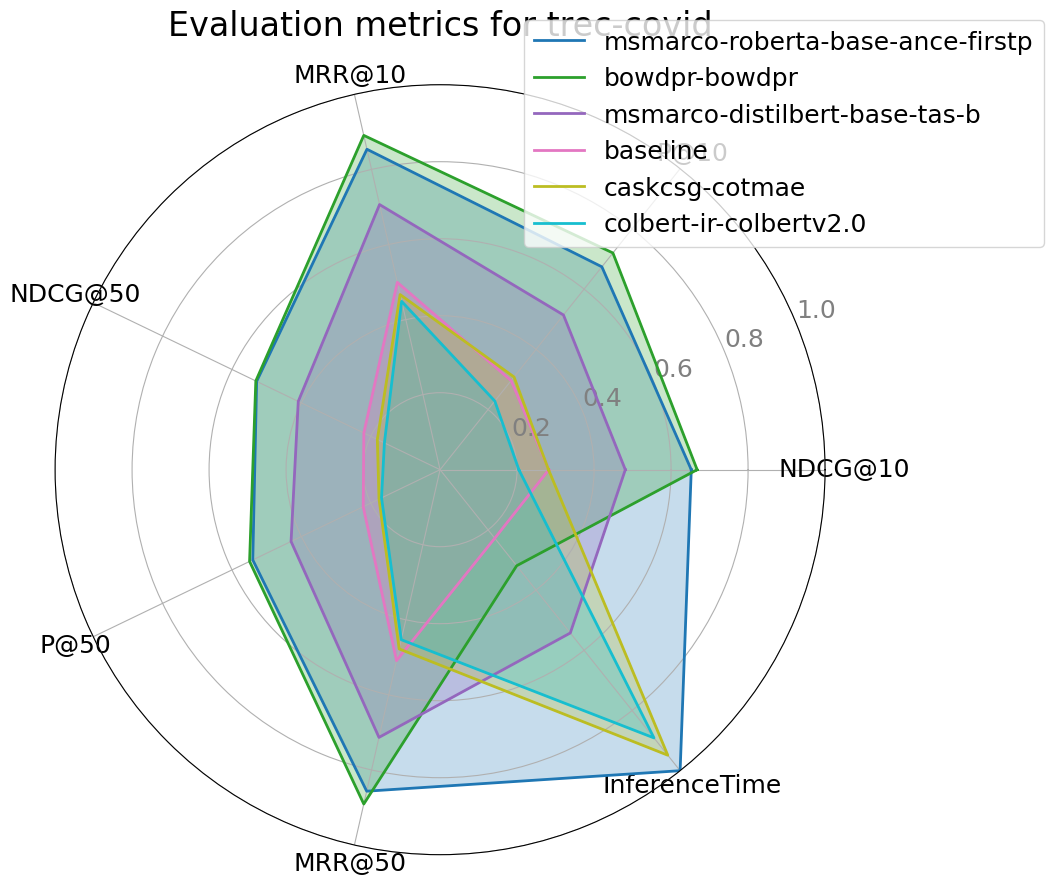

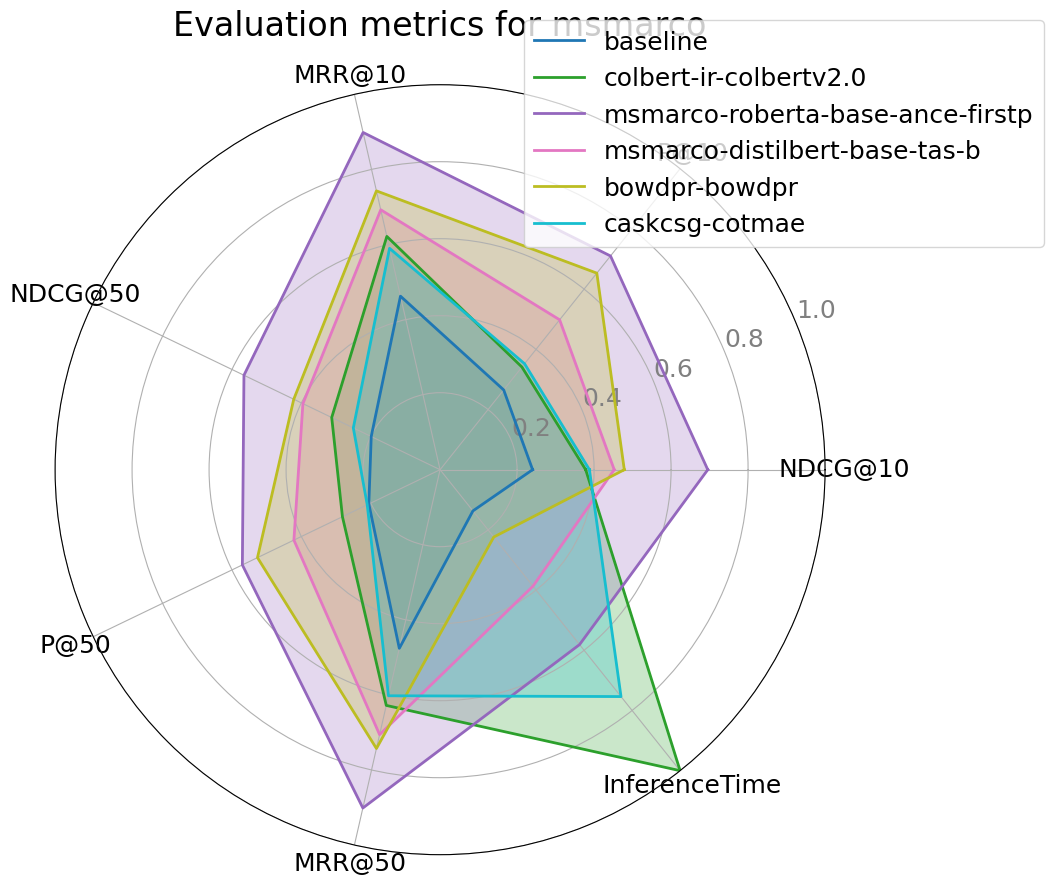

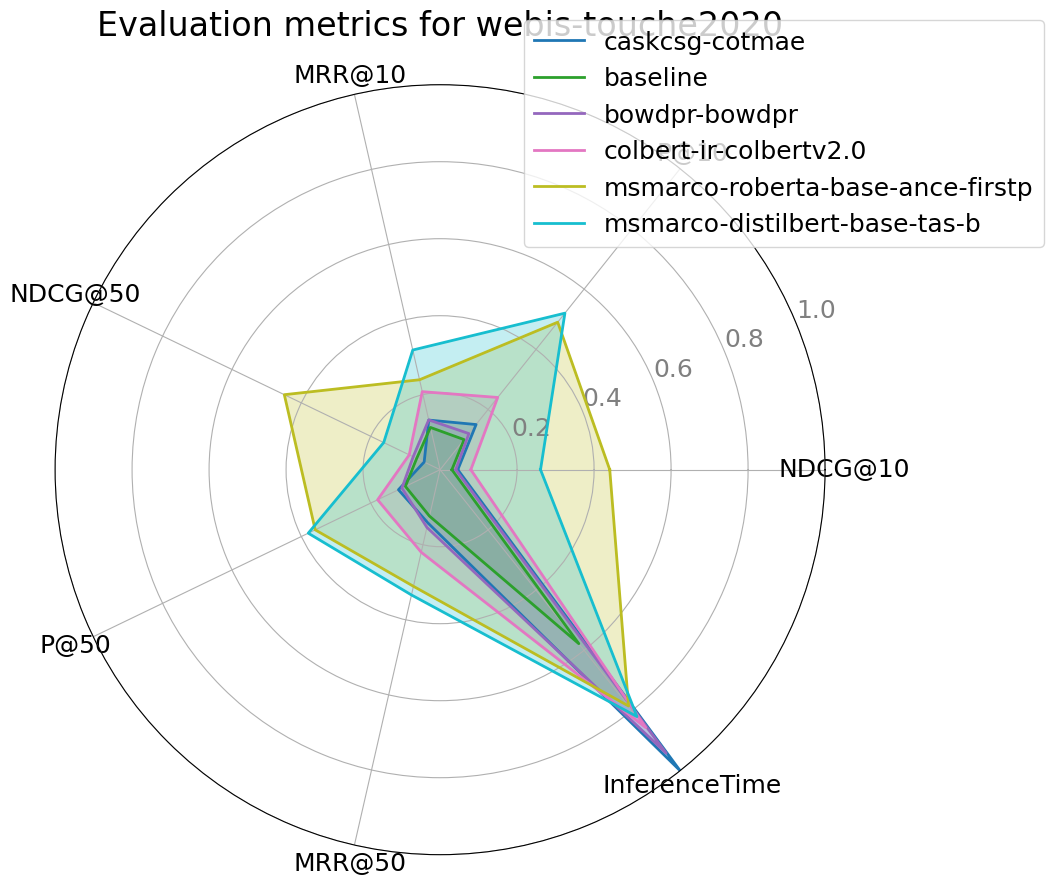

In [11]:
# Plot for one dataset
for dataset_name, results in evaluation_results.items():
  create_radar_plot(results, dataset_name)